# Properly Transforming T to Z Scores for Large Brain Maps

We discovered a strange truncation of strongly negative values when converting from T statistic scores --> P values --> Z scores.  First we will show the strangeness.  

### The task behind the map
This is a group map for a "story" contrast from a language task from the Human Connectome Project (HCP). For [this task](http://www.sciencedirect.com/science/article/pii/S1053811913005272), there are alternating blocks of doing match problems and listening to a story. This contrast is for the "story" blocks.

### The map
We concatenated each single subject cope1.nii.gz image representing this contrast in time, for a total of 486 subjects (timepoints), and ran randomise for 5000 iterations (fsl).

## Viewing the T Statistic Map

Now we can read in the file, and first look at the image itself and the T-distribution.

/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/nilearn/plotting/img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


Here is our map created with randomise for all 486 subjects, for the story contrast


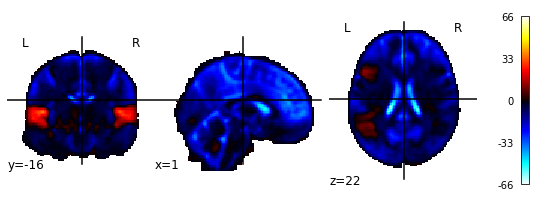

In [1]:
import matplotlib
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline
import nibabel as nib
from nilearn.plotting import plot_stat_map, plot_roi
from scipy.spatial.distance import pdist
from scipy.stats import norm, t
import seaborn as sns

all_copes_file = "../example/tfMRI_LANGUAGE_STORY.nii_tstat1.nii.gz"
all_copes = nib.load(all_copes_file)
plot_stat_map(all_copes)
print("Here is our map created with randomise for all 486 subjects, for the story contrast")

Now I want to point out something about this map - we have a set of strongly negative outliers.

/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.
/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  if sys.path[0] == '':
/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'niba

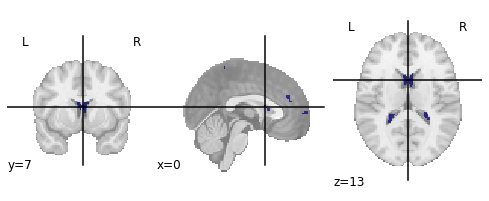

In [2]:
# Function to flag outliers
def plot_outliers(image,n_std=6):
  mr = nib.load(image)
  data = mr.get_data()
  mean = data.mean()
  std = data.std()
  six_dev_up = mean + n_std * std
  six_dev_down = mean - n_std*std
  empty_brain = np.zeros(data.shape)
  empty_brain[data>=six_dev_up] = 1
  empty_brain[data<=six_dev_down] = 1 
  outlier_nii = nib.nifti1.Nifti1Image(empty_brain,affine=mr.get_affine(),header=mr.get_header())
  plot_roi(outlier_nii)

plot_outliers(all_copes_file)

It is a separate problem entirely if those outliers should be there, but for the purposes of this problem, we would want any conversion from T to Z to maintain those outliers. Let's now look at the distribution of the data.

# Viewing the T Distribution

/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.
/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Here is our map created with randomise for all 486 subjects, for the story contrast


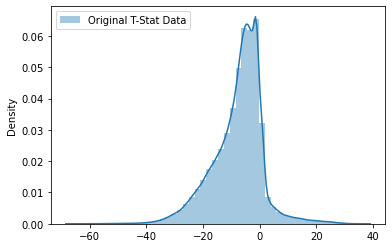

In [4]:
data = all_copes.get_data()
data = data[data!=0]
sns.distplot(data.flatten(), label="Original T-Stat Data")
plt.legend()
print("Here is our map created with randomise for all 486 subjects, for the story contrast")

We have a heavy left tail, meaning lots of strongly negative values.

# Converting from T to P-Values

We next will convert T scores into P values by way of the "survival function" from the scipy.stats t module. The survival function is actually 1 - the cumulative density function (CDF) that will give us the probability (p-value) for each of our random variable (the T). 

![this](http://upload.wikimedia.org/math/d/b/1/db1695bdb2b59b9bd2d9d818b9a3b505.png)

The degrees of freedom should be the number of subjects from which the group map was derived -2.

/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  
/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Here are the p-values created from the t-stat map, including all zeros in the map when we calculate


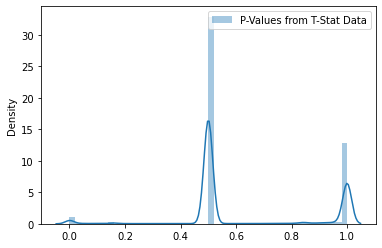

In [5]:
dof=486 - 2 
data = all_copes.get_data()
p_values = t.sf(data, df = dof)
p_values[p_values==1] = 0.99999999999999
sns.distplot(p_values.flatten(), label="P-Values from T-Stat Data")
plt.legend()
print("Here are the p-values created from the t-stat map, including all zeros in the map when we calculate")

# Converting from P-Values to Z-Scores
Now we can use scipy.stats.norm inverse survival function to "undo" the p-values back into normal (Z scores).

/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Here are the z-values created from the t-stat map, including all zeros in the map when we calculate


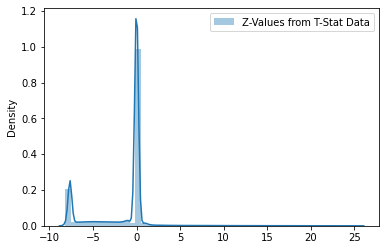

In [6]:
z_values = norm.isf(p_values)
sns.distplot(z_values.flatten(), label="Z-Values from T-Stat Data")
plt.legend()
print("Here are the z-values created from the t-stat map, including all zeros in the map when we calculate")


But now we see something strange. The distribution looks almost truncated. When we look at the new image, the strong negative values (previously outliers in ventricles) aren't there either:

/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  from ipykernel import kernelapp as app
/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  from ipykernel import kernelapp as app
/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will 

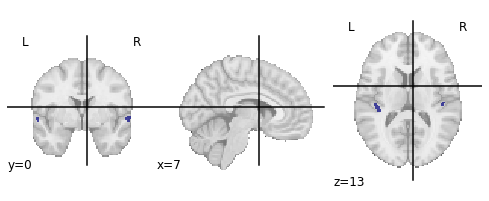

In [8]:
# Need to make sure we look at the same slices :)
def plot_outliers(image,cut_coords,n_std=6):
  mr = nib.load(image)
  data = mr.get_data()
  mean = data.mean()
  std = data.std()
  six_dev_up = mean + n_std * std
  six_dev_down = mean - n_std*std
  empty_brain = np.zeros(data.shape)
  empty_brain[data>=six_dev_up] = 1
  empty_brain[data<=six_dev_down] = 1 
  outlier_nii = nib.nifti1.Nifti1Image(empty_brain,affine=mr.get_affine(),header=mr.get_header())
  plot_roi(outlier_nii,cut_coords=cut_coords)

Z_nii = nib.nifti1.Nifti1Image(z_values,affine=all_copes.get_affine(),header=all_copes.get_header())
nib.save(Z_nii,"../example/Zimage.nii")
plot_outliers("../example/Zimage.nii",cut_coords=(7,0,13))

And here is the problem. The outliers are clearly gone, and it's because the distribution has been truncated:

![img](http://www.vbmis.com/bmi/share/chris/t_to_z/truncated_t_to_z.png)

# Properly Converting T to Z

I found [this paper](http://www.stats.uwo.ca/faculty/aim/2010/JSSSnipets/V23N1.pdf), which summarizes the problem:

![img](http://www.vbmis.com/bmi/share/chris/t_to_z/correct_t_to_z.png)


# Implementing the Correct Transformation from T to Z

This was modified from the code provided in the paper above. Thank you!

/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """Entry point for launching an IPython kernel.
/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


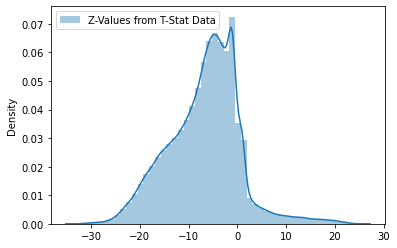

In [9]:
data = all_copes.get_data()

# Let's select just the nonzero voxels
nonzero = data[data!=0]

# We will store our results here
Z = np.zeros(len(nonzero))

# Select values less than or == 0, and greater than zero
c  = np.zeros(len(nonzero))
k1 = (nonzero <= c)
k2 = (nonzero > c)

# Subset the data into two sets
t1 = nonzero[k1]
t2 = nonzero[k2]

# Calculate p values for <=0
p_values_t1 = t.cdf(t1, df = dof)
z_values_t1 = norm.ppf(p_values_t1)

# Calculate p values for > 0
p_values_t2 = t.cdf(-t2, df = dof)
z_values_t2 = -norm.ppf(p_values_t2)
Z[k1] = z_values_t1
Z[k2] = z_values_t2
sns.distplot(Z, label="Z-Values from T-Stat Data")
plt.legend()

# Viewing the new Z Score Map

Did we fix it?

/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  
/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tomo/anaconda3/envs/t2z/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will

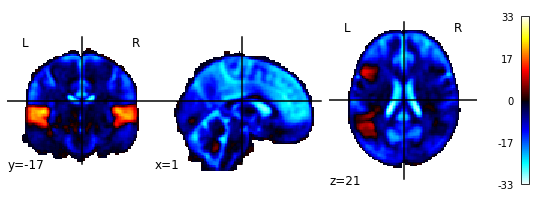

In [11]:
empty_nii = np.zeros(all_copes.shape)
empty_nii[all_copes.get_data()!=0] = Z
Z_nii_fixed = nib.nifti1.Nifti1Image(empty_nii,affine=all_copes.get_affine(),header=all_copes.get_header())
nib.save(Z_nii_fixed,"../example/Zfixed.nii")
plot_stat_map(Z_nii_fixed)

![img](http://www.vbmis.com/bmi/share/chris/t_to_z/fixed_t_to_z.png)